In [62]:

"""
월 차트 조회
"""
import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,vol_lastday,cap,name,exchange
0,010640,1996-01-31,426,571,426,540,8578133,402317,142928000000,진양폴리,KOSPI
1,000325,1996-01-31,615,624,520,594,143596,67591,724000000,노루홀딩스우,KOSPI
2,003060,1996-01-31,159638,218635,146624,217767,2756,950,3484000000,에이프로젠제약,KOSPI
3,006280,1996-01-31,51233,64561,45401,64561,165110,13367,37122000000,녹십자,KOSPI
4,012330,1996-01-31,8449,9277,8007,8394,774650,26275,350054000000,현대모비스,KOSPI
...,...,...,...,...,...,...,...,...,...,...,...
470634,005710,2022-12-02,5740,5820,5710,5780,17084,5917,115813000000,대원산업,KOSDAQ
470635,062970,2022-12-02,3010,3080,2915,3000,54040,26654,27924000000,피피아이,KOSDAQ
470636,290550,2022-12-02,8860,9190,8810,8840,48733,15270,145524000000,디케이티,KOSDAQ
470637,009415,2022-12-02,9350,10350,7900,7900,167222,35788,10285000000,태영건설우,KOSPI


In [63]:
"""
"""
import pandas as pd
from repository import load_financial
from base.time import YearMonth
import sqlite3

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(".cache/cache.db"))
except Exception as e:
    begin = YearMonth(2002, 6)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        # 당일 1000만원 이상 거래 발생 종목만 취급
        df1 = df1[df1["cap"] != 0]
        df1 = df1[df1["vol"] * df1["close"] > 1_000_0000]
        df1 = df1[df1["vol_lastday"] * df1["close"] > 1_000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

layer1 = layer1.reset_index()
layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,매도가,...,매출총이익,영업이익,당기순이익,GP_YoY,O_YoY,E_YoY,GP_QoQ,O_QoQ,E_QoQ,확정실적
0,001750,한양증권,KOSPI,2002-06,2002-07,48366000000,2002-06-28,3800,459290,3810.0,...,NaN,1.223689e+10,NaN,NaN,1.249352,NaN,NaN,0.237975,NaN,2002-1Q
1,036540,SFA반도체,KOSDAQ,2002-06,2002-07,33568000000,2002-06-28,2206,1875710,2337.0,...,6.402941e+09,5.077027e+09,4.278461e+09,-0.305559,-0.365565,-0.334486,0.543414,0.810110,0.957588,2002-1Q
2,049770,동원F&B,KOSPI,2002-06,2002-07,59700000000,2002-06-28,19900,237611,21450.0,...,1.540012e+11,2.955715e+10,1.707015e+10,NaN,NaN,NaN,0.076334,0.185834,0.348800,2002-1Q
3,019175,신풍제약우,KOSPI,2002-06,2002-07,2222000000,2002-06-28,795,460779,810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,006890,태경케미컬,KOSPI,2002-06,2002-07,34452000000,2002-06-28,4350,1846825,3010.0,...,1.137625e+10,4.782999e+09,3.811970e+09,0.378935,0.854827,1.135428,0.810138,3.286834,3.823383,2002-1Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374509,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,9120.0,...,5.696930e+10,4.649376e+09,1.066560e+08,0.732314,1.506782,1.012487,0.575744,0.653779,-4.086029,2022-2Q
374510,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,3360.0,...,2.460088e+10,8.088178e+09,9.213221e+09,0.281257,2.083479,10.759717,0.013266,-0.180116,1.426468,2022-2Q
374511,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,5720.0,...,6.507321e+10,3.600380e+10,6.162755e+10,0.041626,0.020614,1.642062,0.052843,0.377019,15.219352,2022-2Q
374512,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,2995.0,...,-1.490204e+09,-4.446674e+09,-8.292667e+09,0.783547,0.575632,0.044914,1.462374,1.151010,1.176256,2022-2Q


In [68]:
layer1["확정실적"] = str(layer1["확정실적"])
layer1.to_sql("layer1", sqlite3.connect(".cache/cache.db"), if_exists="replace", index=False)

374514

In [84]:

import numpy as np
import random

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = ["GP_YoY", "GP_QoQ", "O_YoY", "O_QoQ"]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("1/P")
layer2["1/P"] = 1 / layer2["P"]

factors.append("random/P")
layer2["random/P"] = [random.random() for _ in layer2.index] / layer2["P"]

result = pd.DataFrame()
yms = layer2["매수년월"].unique()
rank_scale = 100

recipes = [
    {
        "GP/P": 10,
        "1/P": 20,
    },
    {
        "GP/P": 10,
        "1/P": 24,
    },
    {
        "GP/P": 10,
        "1/P": 20,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 10,
        "1/P": 24,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 10,
        "1/P": 24,

        "GP_YoY": 1,
        "GP_QoQ": 3,
        "O_YoY": 1,
        "O_QoQ": 3,
    },
    {
        "GP/P": 10,
        "1/P": 24,

        "GP_YoY": 1,
        "GP_QoQ": 4,
        "O_YoY": 2,
        "O_QoQ": 4,
    },
    {
        "GP/P": 10,
        "1/P": 24,

        "GP_YoY": 2,
        "GP_QoQ": 5,
        "O_YoY": 3,
        "O_QoQ": 5,
    },
]

print(pd.DataFrame(recipes))

# for ym in [ym for ym in yms if ym > '2010']:
for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_rank = f"{factor}_rank"
        df[colname_rank] = np.ceil(df[factor].rank(ascending=False, method="min", pct=True) * rank_scale)
        df[f"{factor}_power"] = (df[factor] - df[factor].mean()) / df[factor].std()

    for i in range(len(recipes)):
        factor = f"super{i}"
        df[factor] = 1 / sum([(df[f"{k}_rank"] * v) ** 1.5 for k, v in recipes[i].items()]) * 100
        df[f"{factor}_power"] = (df[factor] - df[factor].mean()) / df[factor].std()
        df[f"{factor}_rank"] = np.ceil(df[factor].rank(ascending=False, method="min", pct=True) * rank_scale)

    result = pd.concat([result, df])

# factors = ["super"] + factors
factors = [f"super{i}" for i in range(len(recipes))] + factors
result

   GP/P  1/P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0    10   20     NaN     NaN    NaN    NaN
1    10   24     NaN     NaN    NaN    NaN
2    10   20     1.0     2.0    1.0    2.0
3    10   24     1.0     2.0    1.0    2.0
4    10   24     1.0     3.0    1.0    3.0
5    10   24     1.0     4.0    2.0    4.0
6    10   24     2.0     5.0    3.0    5.0
2022-10

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,매도가,...,super3_rank,super4,super4_power,super4_rank,super5,super5_power,super5_rank,super6,super6_power,super6_rank
0,001750,한양증권,KOSPI,2002-06,2002-07,48366000000,2002-06-28,3800,459290,3810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,036540,SFA반도체,KOSDAQ,2002-06,2002-07,33568000000,2002-06-28,2206,1875710,2337.0,...,59.0,0.001408,-0.322416,58.0,0.001379,-0.331985,56.0,0.001319,-0.328104,56.0
2,049770,동원F&B,KOSPI,2002-06,2002-07,59700000000,2002-06-28,19900,237611,21450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,019175,신풍제약우,KOSPI,2002-06,2002-07,2222000000,2002-06-28,795,460779,810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,006890,태경케미컬,KOSPI,2002-06,2002-07,34452000000,2002-06-28,4350,1846825,3010.0,...,52.0,0.001549,-0.291540,52.0,0.001541,-0.284909,49.0,0.001529,-0.250818,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374509,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,9120.0,...,47.0,0.001755,-0.239445,45.0,0.001730,-0.194050,43.0,0.001699,-0.124333,40.0
374510,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,3360.0,...,51.0,0.001582,-0.314342,51.0,0.001515,-0.304190,51.0,0.001437,-0.283190,50.0
374511,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,5720.0,...,35.0,0.002207,-0.044285,35.0,0.002086,-0.012716,34.0,0.001924,0.011598,34.0
374512,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,2995.0,...,24.0,0.003004,0.300362,22.0,0.002948,0.427531,19.0,0.002874,0.586504,15.0


24/24[{'GP/P': 10, '1/P': 20}, {'GP/P': 10, '1/P': 24}, {'GP/P': 10, '1/P': 20, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 10, '1/P': 24, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 10, '1/P': 24, 'GP_YoY': 1, 'GP_QoQ': 3, 'O_YoY': 1, 'O_QoQ': 3}, {'GP/P': 10, '1/P': 24, 'GP_YoY': 1, 'GP_QoQ': 4, 'O_YoY': 2, 'O_QoQ': 4}, {'GP/P': 10, '1/P': 24, 'GP_YoY': 2, 'GP_QoQ': 5, 'O_YoY': 3, 'O_QoQ': 5}]


,spearman,top,h5,h10,t5,h5-t5,h5-t5+mdd5,mean,median,mdd5
factor,,,,,,,,,,
super3,-0.877552,0.769432,0.639460,0.508054,0.047085,0.592375,0.113983,0.161665,0.097020,-0.478392
super4,-0.892397,0.782906,0.625663,0.514273,0.041168,0.584495,0.090531,0.161483,0.102919,-0.493964
super2,-0.900918,0.783456,0.623331,0.504979,0.038604,0.584727,0.102788,0.161695,0.098866,-0.481939
super5,-0.900618,0.757060,0.614688,0.513581,0.041387,0.573300,0.077572,0.161948,0.096793,-0.495728
super1,-0.869979,0.776159,0.593467,0.497476,0.051528,0.541939,0.052559,0.159352,0.100991,-0.489379
super0,-0.894989,0.771172,0.584398,0.481186,0.035804,0.548594,0.039995,0.158787,0.104355,-0.508599
super6,-0.897438,0.743253,0.574075,0.513878,0.033356,0.540719,0.054180,0.161662,0.118709,-0.486539
1/P,-0.772133,0.522937,0.526279,0.485742,0.065989,0.460290,-0.031904,0.153539,0.089841,-0.492194
random/P,-0.794803,0.479233,0.500428,0.419557,0.075468,0.424960,-0.061625,0.151702,0.123069,-0.486585


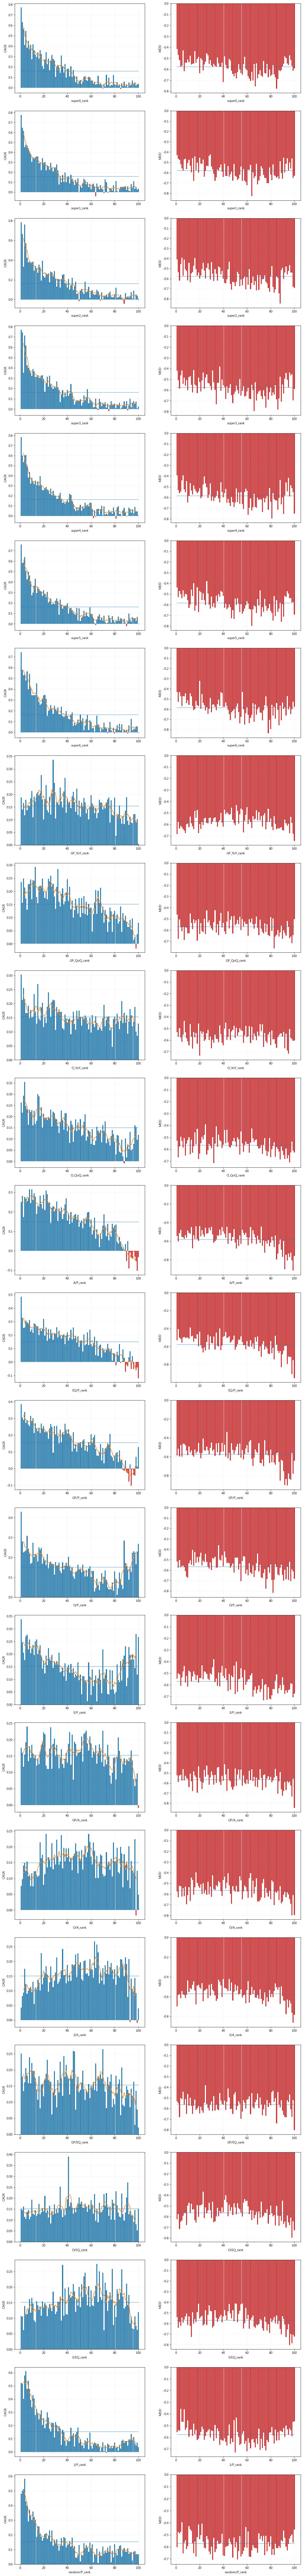

In [85]:
import matplotlib.pyplot as plt
from base import cagr, mdd
from base.time import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

fig, subplots = plt.subplots(len(factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(factors))

summary = pd.DataFrame()
for i in range(len(factors)):
    print(f"\r{i + 1}/{len(factors)}", end="")
    factor = factors[i]
    colname_rank = f"{factor}_rank"
    rank = sorted(set(result[colname_rank].dropna()))
    mean_by_rank = []
    cagr_by_rank = []
    mdd_by_rank = []
    for r in rank:
        rankers = result[result[colname_rank] == r]
        return_by_ym = rankers.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(rankers["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_rank.append(return_by_ym.mean())
        cagr_by_rank.append(cagr(1, last, rankers["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_rank.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_rank_series = pd.Series(cagr_by_rank)
    mdd_by_rank_series = pd.Series(mdd_by_rank)

    ax1.set_xlabel(colname_rank)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(rank, cagr_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_rank])
    ax1.plot(rank, [cagr_by_rank_series.mean() for _ in rank], alpha=0.5)
    ax1.plot(rank, cagr_by_rank_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_rank)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(rank, mdd_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_rank])
    ax2.plot(rank, [mdd_by_rank_series.mean() for _ in rank], alpha=0.5)

    corr = pd.DataFrame({colname_rank: rank, "cagr": cagr_by_rank}).corr(method="spearman")
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_rank]["cagr"],
            "top": cagr_by_rank_series.head(1).mean(),
            "h5": cagr_by_rank_series.head(5).mean(),
            "h10": cagr_by_rank_series.head(10).mean(),
            "t5": cagr_by_rank_series.tail(5).mean(),
            "h5-t5": cagr_by_rank_series.head(5).mean() - cagr_by_rank_series.tail(5).mean(),
            "h5-t5+mdd5": cagr_by_rank_series.head(5).mean() - cagr_by_rank_series.tail(
                5).mean() + mdd_by_rank_series.head(5).mean(),
            "mean": cagr_by_rank_series.mean(),
            "median": cagr_by_rank_series.median(),
            "mdd5": mdd_by_rank_series.head(5).mean(),
        }).to_frame(factor).T
    ])

print(recipes)

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(".cache/cache.db"), if_exists="replace")
summary = summary.sort_values("h5", ascending=False)
summary

In [89]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super2"
head = 20
result2 = result[~result["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
# result2 = result2[result2["EQ/P"].rank(ascending=False, method="min", pct=True) < 0.8]
# result2 = result2[result2["A/P"].rank(ascending=False, method="min", pct=True) < 0.8]
# result2 = result2[result2["GP/P"].rank(ascending=False, method="min", pct=True) < 0.8]
# result2 = result2[result2["1/P"].rank(ascending=False, method="min", pct=True) < 0.5]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)
result2.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", factor]]

code       종목명       수익률     거래소         매수일  \
매수년월    매도년월                                                             
2002-06 2002-07 28      017550     수산중공업 -0.165746   KOSPI  2002-06-28   
                82      027740       마니커 -0.042055   KOSPI  2002-06-28   
                255     033540       파라텍 -0.031746  KOSDAQ  2002-06-28   
                458     006090      사조오양 -0.023342   KOSPI  2002-06-28   
                491     006730     서부T&D  0.151515  KOSDAQ  2002-06-28   
...                        ...       ...       ...     ...         ...   
2022-10 2022-11 374130  071950       코아스  0.012706   KOSPI  2022-10-31   
                373009  088790        진도  0.093933   KOSPI  2022-10-31   
                372594  046310     백금T&A  0.318841  KOSDAQ  2022-10-31   
                372150  208350  지란지교시큐리티  0.056029  KOSDAQ  2022-10-31   
                373371  098660      에스티오 -0.230556  KOSDAQ  2022-10-31   

                               매도일   매수가     매도가    super2  
매수년월    매도년월                                                
2002-06 2002-07 28      2002-07-31   362   302.0  0.079218  
                82      2002-07-31  3329  3189.0  0.061211  
                255     2002-07-31    63    61.0  0.044213  
                458     2002-07-31  1885  1841.0  0.042153  
                491     2002-07-31    33    38.0  0.037557  
...                            ...   ...     ...       ...  
2022-10 2022-11 374130  2022-11-30   787   797.0  0.015721  
                373009  2022-11-30  2555  2795.0  0.015457  
                372594  2022-11-30  2415  3185.0  0.014585  
                372150  2022-11-30  4105  4335.0  0.014371  
                373371  2022-11-30  3600  2770.0  0.014316  

[4900 rows x 9 columns]

In [90]:
from base import cagr, mdd
from base.time import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                         MDD      Mean
전략    0.713186  (-0.41473955183660294, (2008-06, 2008-10))  0.051010
벤치마크  0.162151   (-0.5373814900711391, (2007-07, 2008-10))  0.014943


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2002-06,2002-07,-0.002524,0.040095,0.04,0.997476,1.040095
2002-07,2002-08,0.034868,0.072600,0.04,1.032256,1.115606
2002-08,2002-09,-0.149046,-0.067094,0.08,0.878402,1.040756
2002-09,2002-10,0.045796,0.004257,-0.04,0.918630,1.045186
2002-10,2002-11,0.052133,-0.021818,-0.07,0.966520,1.022382
...,...,...,...,...,...,...
2022-06,2022-07,0.064926,0.091203,0.03,22.843086,60386.198307
2022-07,2022-08,0.007584,0.006682,-0.00,23.016328,60789.679810
2022-08,2022-09,-0.153737,-0.173039,-0.02,19.477855,50270.710255


전체 개월 수      245.00
초과수익 개월 수    174.00
아웃퍼폼 총합       10.59
언더퍼폼 총합       -1.55
dtype: float64

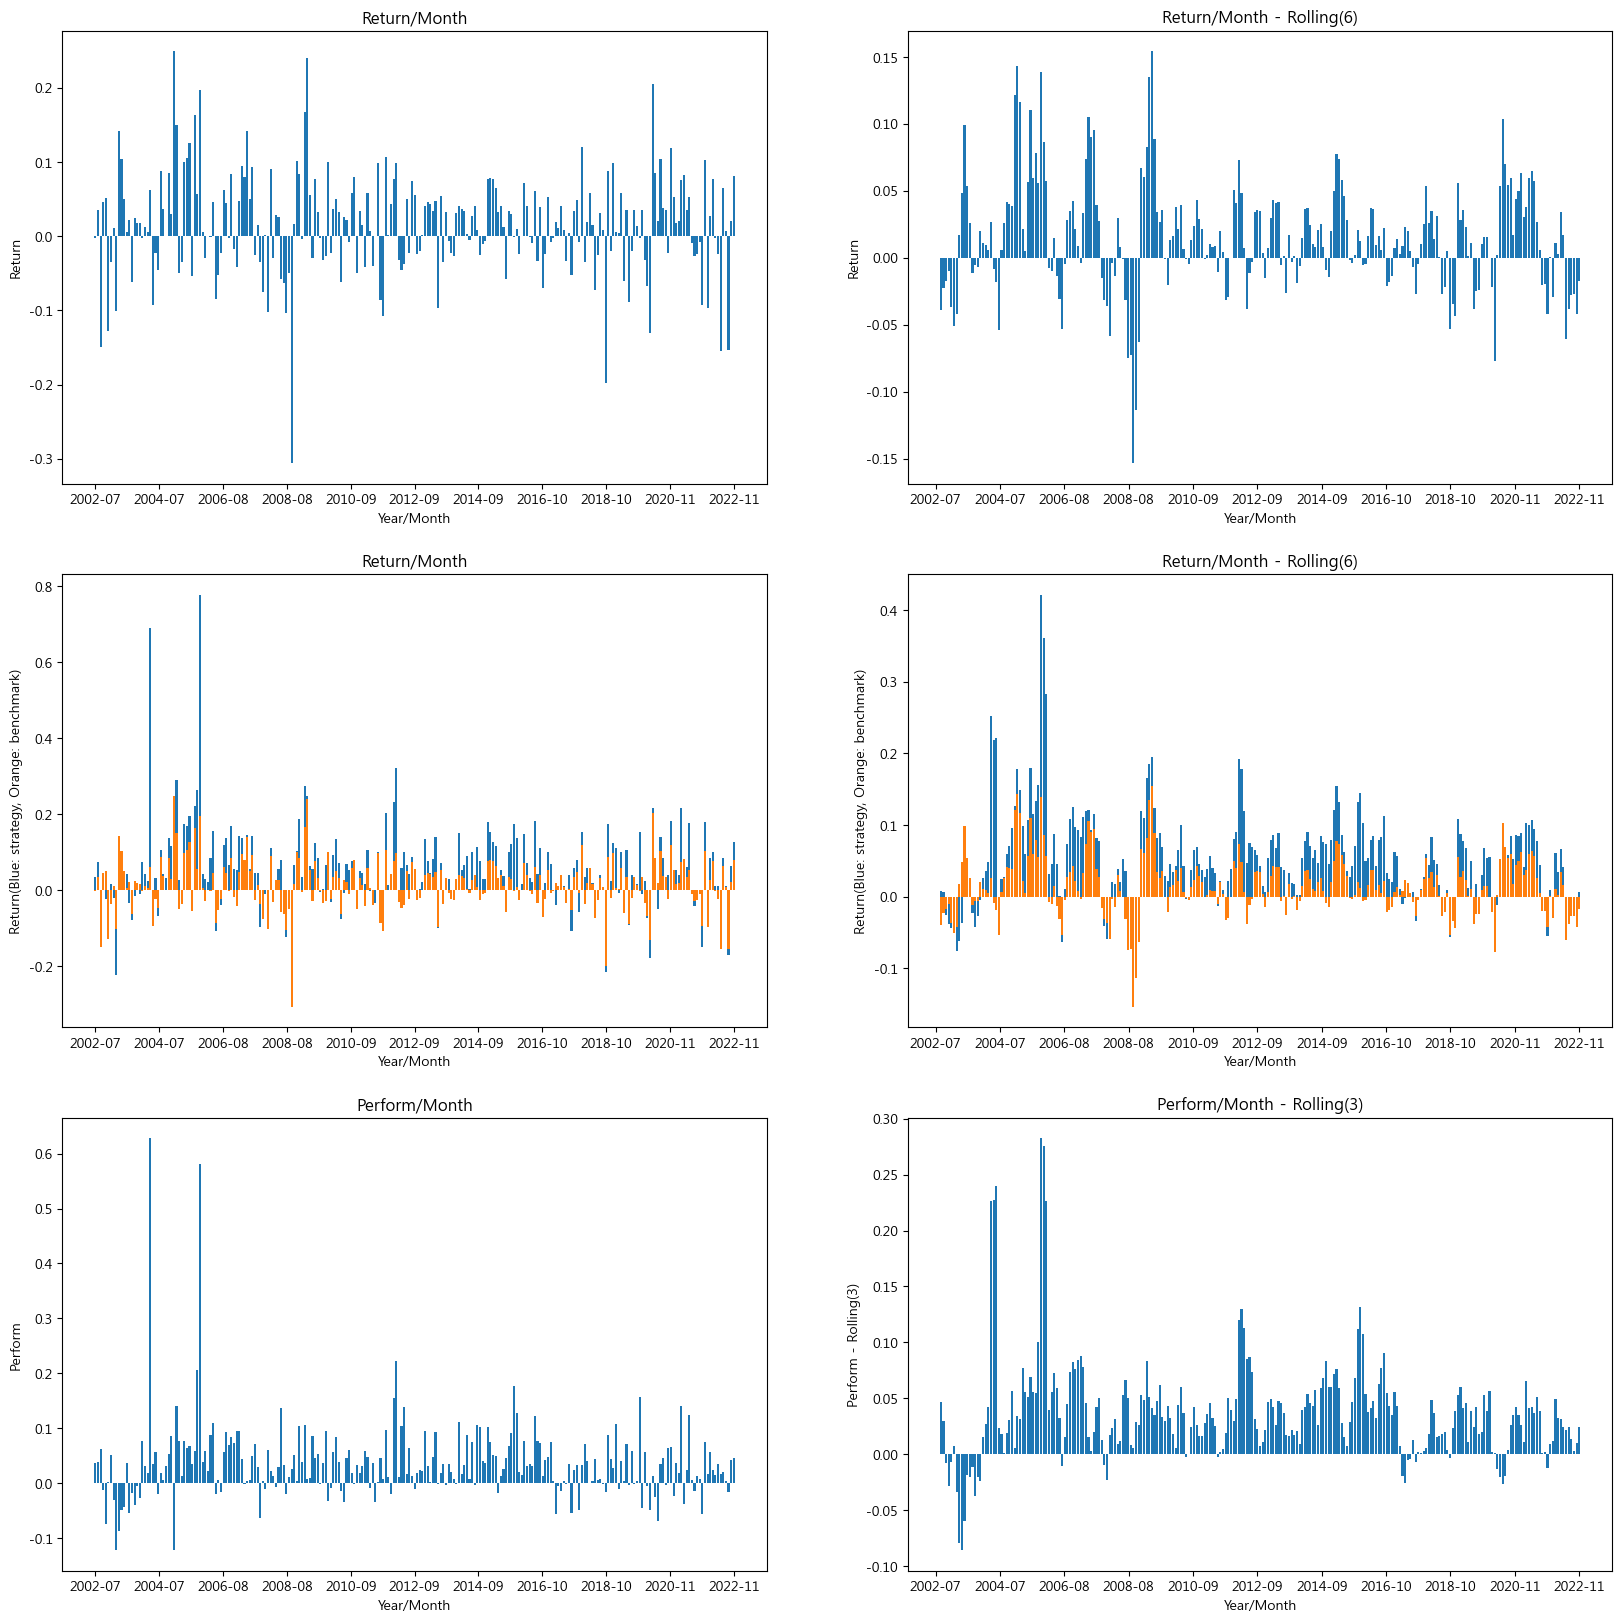

In [79]:
import numpy as np
import matplotlib.pyplot as plt

rank = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"Return/Month")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(rank, revisions["벤치마크 수익률"])

window = 3
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(rank, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title(f"Return/Month")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(rank, revisions["전략 수익률"])
ax3.bar(rank, revisions["벤치마크 수익률"])

ax4.set_title("Return/Month - Rolling(6)")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(rank, revisions["전략 수익률"].rolling(window).mean())
ax4.bar(rank, revisions["벤치마크 수익률"].rolling(window).mean())

ax5.set_title("Perform/Month")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(rank, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax6.set_title(f"Perform/Month - Rolling({window})")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({window})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(rank, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})